# A Lucky Tractor

***Xiaodong DENG*** (<a href='mailto:xd.deng.r@gmail.com'>xd.deng.r@gmail.com</a>)

This is one part of the 3rd ranking solution (out of 93 teams) to ***Asia Actuarial Analytics Challenge 2017*** hosted by *Singapore Actuarial Society* (https://www.kaggle.com/c/asia-actuarial-analytics-challenge-2017).


## Environment Setting-Up

In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb

%matplotlib inline

np.random.seed(1000)

os.chdir("../")

## Load Data

In [2]:
# Remove CustomerID since it's not "useful".
dat_train_raw =  pd.read_csv("data/SAS_Train_Data_v3.csv")
dat_train_raw = dat_train_raw[np.setdiff1d(dat_train_raw.columns, "CustomerID")]

dat_test_raw =  pd.read_csv("data/SAS_Test_Data_v3.csv")
list_test_customer_id = dat_test_raw.CustomerID
dat_test_raw = dat_test_raw[np.setdiff1d(dat_test_raw.columns, "CustomerID")]

print dat_train_raw.shape
print dat_test_raw.shape

(30000, 21)
(11186, 21)


## Simple Feature Transformation

In [3]:
# Address a few data "issues"

dat_train_raw.loc[dat_train_raw.NoContacts_PrevCampaigns==0, 'Pdays'] = 999
dat_train_raw.loc[dat_train_raw.NoContacts_PrevCampaigns==0, 'Prev_Outcome'] = 'nonexistent'
dat_train_raw.loc[dat_train_raw.Pdays==999, 'Prev_Outcome'] = 'nonexistent'

dat_test_raw.loc[dat_test_raw.NoContacts_PrevCampaigns==0, 'Pdays'] = 999
dat_test_raw.loc[dat_test_raw.NoContacts_PrevCampaigns==0, 'Prev_Outcome'] = 'nonexistent'
dat_test_raw.loc[dat_test_raw.Pdays==999, 'Prev_Outcome'] = 'nonexistent'
    
    

def FUN_categorical_to_numerical(dat, feature_name, label_column_name):
    '''
    This function is to convert categorical features into ordered features (then numerical features).
    We order the feature classes according to the proportion falling in outcome class 1.
    Then we split this predictor as if it were an ordered predictor.
    '''
    temp = dat[[feature_name, label_column_name]].pivot_table(index=feature_name, columns=label_column_name, aggfunc=len)[[0, 1]]
    temp['total_count'] = (temp[1] + temp[0])
    temp['proportion_of_positive'] = (temp[1]/temp['total_count'])
    temp = temp.sort_values("proportion_of_positive")
    temp['rank'] = range(temp.shape[0])
    
    mapping={}
    for i in zip(temp.index, temp['rank']):
        mapping[i[0]]=i[1]

    return mapping


# List the categorical variables
variables_to_encode = dat_train_raw.columns[dat_train_raw.dtypes=="object"]

# Note: the splitting mapping should be derived based on Train data and to be used on both Train and Test data.
for j in variables_to_encode:
    transform_mapping = FUN_categorical_to_numerical(dat_train_raw, j, "Outcome")
    dat_train_raw[j] = dat_train_raw[j].map(transform_mapping)
    dat_test_raw[j] = dat_test_raw[j].map(transform_mapping)

In [4]:
dat_test_raw.head()

,Age,Contact_Method,Contact_Month,Contact_WeekDay,Credit_Default,Education_Level,Emp_Var_Rate,Euribor3m,Housing_Loan,Job,...,Monthly_CCI,Monthly_CPI,NoContacts_Current_Campaign,NoContacts_PrevCampaigns,No_Employed,Outcome,Pdays,Personal_Loan,Prev_Outcome,Sex
0,34,1,6,3,1,5,-1.8,1.250,1,9,...,-46.2,92.893,2,0,5099.1,0,999,1,0,0
1,55,1,2,1,0,4,1.4,4.963,1,1,...,-36.1,93.444,2,0,5228.1,0,999,1,0,0
2,53,0,0,3,1,5,1.1,4.856,1,9,...,-36.4,93.994,1,0,5191.0,0,999,2,0,0
3,32,1,0,3,1,3,-1.8,1.244,1,0,...,-46.2,92.893,4,1,5099.1,0,999,1,0,0
4,56,0,8,0,1,4,-0.1,4.153,2,10,...,-42.0,93.200,1,0,5195.8,0,999,1,0,1


## Training Model

In [5]:
feature_columns = np.setdiff1d(dat_train_raw.columns, "Outcome")

In [6]:
dtrain = xgb.DMatrix(dat_train_raw[feature_columns], label = dat_train_raw.Outcome)
dtest = xgb.DMatrix(dat_test_raw[feature_columns])

final_params = {'objective':"binary:logistic",
                'eta':0.03,
                'max_depth':6,
                'subsample':0.6,
                'colsample_bylevel':0.9,
                'eval_metric':'auc'}

bst = xgb.train(final_params, dtrain, num_boost_round=200)

## Making Prediction

In [7]:
result = bst.predict(dtest)

to_submit = pd.DataFrame({"CustomerId":list_test_customer_id,
                          "Outcome":result})
to_submit.head()

,CustomerId,Outcome
0,xlt431ux,0.217607
1,tmm599cn,0.041143
2,ijg236uf,0.032244
3,xqe861ux,0.139725
4,sfa266vj,0.140414


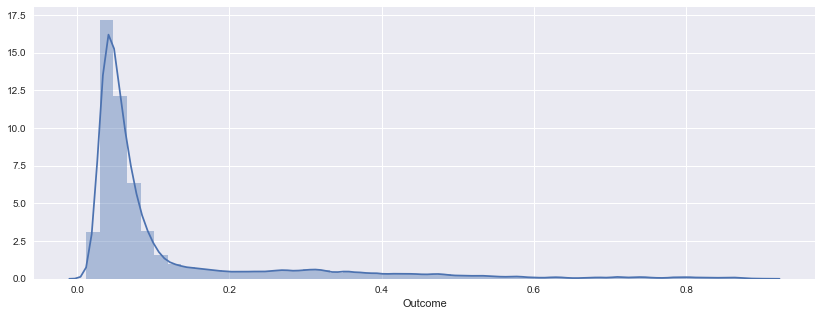

In [8]:
plt.figure(figsize=(14,5))
sns.distplot(to_submit.Outcome)

In [9]:
# to_submit.to_csv("to_submit_Apr_27.csv", index=False)

## Feature Importance Summary

In [10]:
feature_importance = pd.DataFrame({'weight':bst.get_score(importance_type='weight'),
                                      'gain':bst.get_score(importance_type='gain')},
                                    columns=['weight', 'gain'])

,weight,gain
Euribor3m,1589,7.183052
Age,1524,3.350808
Job,849,3.487242
NoContacts_Current_Campaign,803,3.628028
Education_Level,704,3.431314
Contact_WeekDay,650,4.705276
Contact_Month,639,4.175492
Monthly_CCI,606,10.618265
Pdays,407,8.521599
Monthly_CPI,349,3.776362


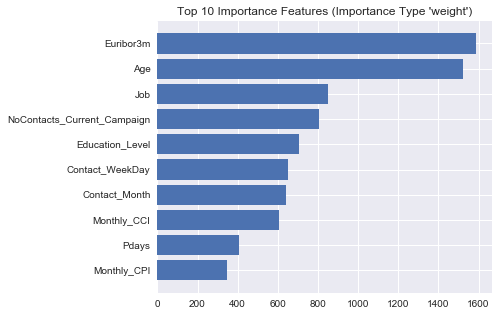

In [11]:
feature_importance.sort_values("weight", inplace=True, ascending=False)

plt.figure(figsize=(6,5))
plt.barh(range(10), list(reversed(feature_importance.weight.head(10))))
plt.yticks(range(10), list(reversed(feature_importance.index[:10])))
plt.title("Top 10 Importance Features (Importance Type 'weight')")

feature_importance.head(10)

,weight,gain
No_Employed,217,108.532030
Prev_Outcome,84,22.538321
Monthly_CCI,606,10.618265
Pdays,407,8.521599
Euribor3m,1589,7.183052
Emp_Var_Rate,182,6.222029
Contact_WeekDay,650,4.705276
Contact_Method,189,4.327922
Contact_Month,639,4.175492
Monthly_CPI,349,3.776362


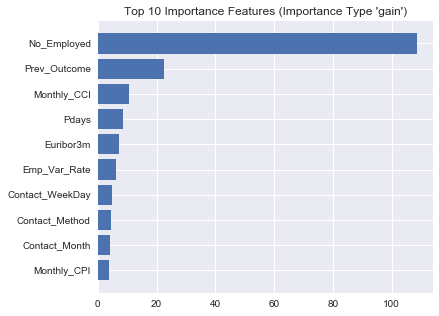

In [12]:
feature_importance.sort_values("gain", inplace=True, ascending=False)

plt.figure(figsize=(6,5))
plt.barh(range(10), list(reversed(feature_importance.gain.head(10))))
plt.yticks(range(10), list(reversed(feature_importance.index[:10])))
plt.title("Top 10 Importance Features (Importance Type 'gain')")

feature_importance.head(10)